In [1]:
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda:1



In [7]:
# Step 1: Import necessary libraries
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import custom modules (assuming they are in the same directory)
from models.vqvae_model import VQVAE
from dataset.shapenet_dataset import Shapes3dDataset, PointCloudField, PointsField, VoxelsField

# Step 2: Define utility functions
# Load the model from a checkpoint
def load_model_from_checkpoint(checkpoint_path, device='cuda:1'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    args = checkpoint['args']
    
    # Reconstruct the model with the same architecture
    model = VQVAE(
        in_channels=1, 
        num_hiddens=128, 
        num_residual_layers=2, 
        num_residual_hiddens=32,
        num_embeddings=512, 
        embedding_dim=64, 
        commitment_cost=0.25
    ).to(device)
    
    model.load_state_dict(checkpoint['model'])
    model.eval()  # Set model to evaluation mode
    
    return model, args

# Prepare a subset dataloader
def prepare_subset_dataloader(dataset_path, batch_size=32, subset_size=20):
    fields = {
        'pointcloud': PointCloudField('pointcloud.npz'),
        'points': PointsField('points.npz', unpackbits=True),
        'voxels': VoxelsField('model.binvox')
    }
    dataset = Shapes3dDataset(dataset_path, fields, split='test')

    # Shuffle and select a subset
    indices = np.random.permutation(len(dataset))[:subset_size]
    subset = torch.utils.data.Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    return dataloader

# Run inference on the test dataset
def run_inference(model, dataloader, device='cuda:1'):
    model.eval()  # Ensure the model is in evaluation mode
    all_reconstructions = []
    all_originals = []
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for data in dataloader:
            data_input = data['voxels'].unsqueeze(1).type(torch.FloatTensor).to(device)
            _, reconstructed_output, _ = model(data_input)
            reconstructed_output_np = reconstructed_output.squeeze().cpu().numpy()
            original_np = data['voxels'].cpu().numpy()
            all_reconstructions.append(reconstructed_output_np)
            all_originals.append(original_np)
    
    return all_reconstructions, all_originals

# Visualization functions
def plot_voxels(voxels, title="Voxel Data"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxels, edgecolor='k')
    ax.set_title(title)
    plt.show()

def plot_voxel_slices(voxels, num_slices=8, title="Voxel Slices"):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 15))
    step = voxels.shape[0] // num_slices
    for i in range(num_slices):
        axes[i].imshow(voxels[i * step], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

def visualize_reconstruction(original, reconstructed):
    # Visualize a few slices from the original and reconstructed voxel data
    plot_voxel_slices(original, num_slices=8, title="Original Voxel Slices")
    plot_voxel_slices(reconstructed, num_slices=8, title="Reconstructed Voxel Slices")

    # Optional: Visualize the 3D voxel data
    plot_voxels(original > 0.5, title="Original Voxel Data")
    plot_voxels(reconstructed > 0.5, title="Reconstructed Voxel Data")

# Step 3: Load the model from a checkpoint
checkpoint_path = 'checkpoints/epoch_260.pt'
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model, args = load_model_from_checkpoint(checkpoint_path, device)

# Step 4: Prepare the subset dataloader
# Adjust the batch size for inference and subset size
inference_batch_size = 32  # Adjust as needed
subset_size = 100  # Number of samples to use for inference
subset_dataloader = prepare_subset_dataloader(args.dataset_path, inference_batch_size, subset_size)




{'02691156': 0, '02828884': 1, '02933112': 2, '02958343': 3, '03001627': 4, '03211117': 5, '03636649': 6, '03691459': 7, '04090263': 8, '04256520': 9, '04379243': 10, '04401088': 11, '04530566': 12}
{'04256520': {'id': '04256520', 'name': 'sofa,couch,lounge'}, '02691156': {'id': '02691156', 'name': 'airplane,aeroplane,plane'}, '03636649': {'id': '03636649', 'name': 'lamp'}, '04401088': {'id': '04401088', 'name': 'telephone,phone,telephone set'}, '04530566': {'id': '04530566', 'name': 'vessel,watercraft'}, '03691459': {'id': '03691459', 'name': 'loudspeaker,speaker,speaker unit,loudspeaker system,speaker system'}, '03001627': {'id': '03001627', 'name': 'chair'}, '02933112': {'id': '02933112', 'name': 'cabinet'}, '04379243': {'id': '04379243', 'name': 'table'}, '03211117': {'id': '03211117', 'name': 'display,video display'}, '02958343': {'id': '02958343', 'name': 'car,auto,automobile,machine,motorcar'}, '02828884': {'id': '02828884', 'name': 'bench'}, '04090263': {'id': '04090263', 'name

In [8]:


# Step 5: Run inference on the subset of the test dataset
reconstructed_outputs, original_outputs = run_inference(model, subset_dataloader, device)

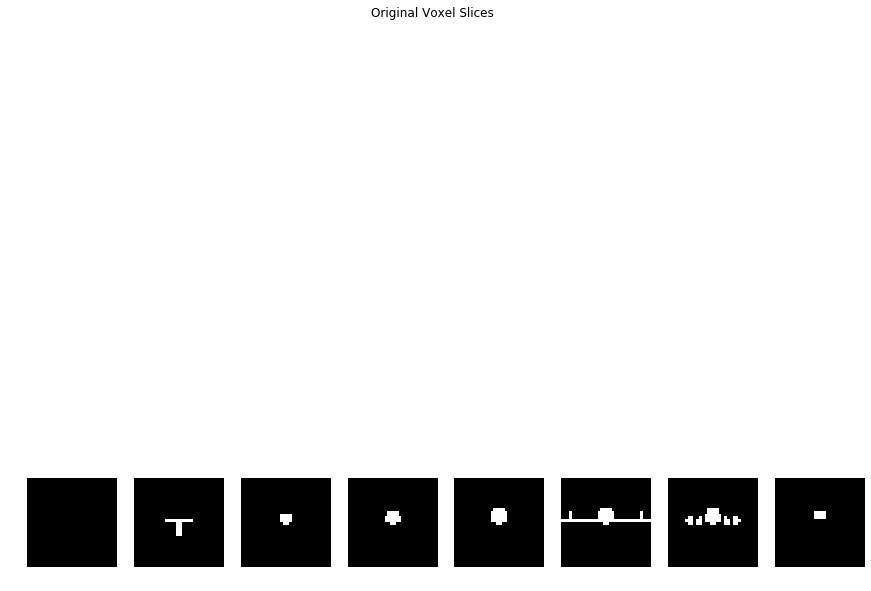

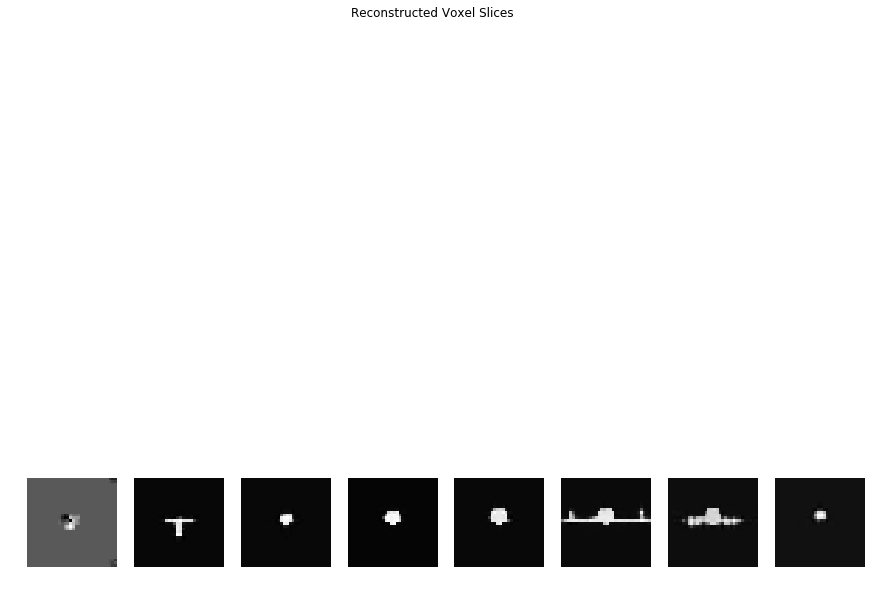

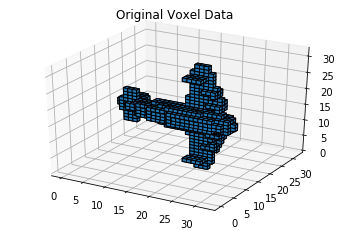

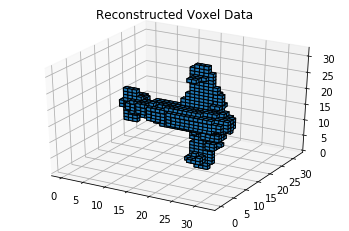

In [27]:


# Step 6: Visualize the reconstructed output and compare with the original
# Visualize a single example for comparison
example_index = 1  # Change this index to visualize different examples
original_example = original_outputs[example_index][0]
reconstructed_example = reconstructed_outputs[example_index][0]

visualize_reconstruction(original_example, reconstructed_example)
